# Upsampling with SMOTE (II)
### This notebooks wants to reproduce the experiment carried out on notebook 'SMOTE Upsampling (Old dataset, with crash)', which was work done on a dataset now replaced. The XGBoost test carried out on the upsampled dataset lead to a crash, which seems to be known as in the discussion here linked:

https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/83003

In [2]:
# Custom scripts
import sys
sys.path.append('../04_scripts')
import constants as const
import data_handler as dh
import data_processor as dp
import xgb_handler as xh
import plot_handler as ph

# python libs
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import re

## Control Overfitting

When you observe high training accuracy, but low test accuracy, it is likely that you encountered overfitting problem.

There are in general two ways that you can control overfitting in XGBoost:

### The first way is to directly control model complexity.

- This includes max_depth, min_child_weight and gamma.

- The second way is to add randomness to make training robust to noise.

- This includes subsample and colsample_bytree.

- You can also reduce stepsize eta. Remember to increase num_round when you do so.

## Handle inbalanced Dataset

For common cases such as ads clickthrough log, the dataset is extremely imbalanced. This can affect the training of XGBoost model, and there are two ways to improve it.

- If you care only about the overall performance metric (AUC) of your prediction

- Balance the positive and negative weights via scale_pos_weight

- Use AUC for evaluation

If you care about predicting the right probability

- In such a case, you cannot re-balance the dataset

- Set parameter max_delta_step to a finite number (say 1) to help convergence

In [3]:
pd.options.display.float_format = '{:,.3f}'.format # Limit output to 3 decimal places.
pd.set_option('display.max_columns', None)

In [3]:
df_bise_classifications_extended = dh.load_df_from_csv('bise_classifications_extended.csv.zip')

In [4]:
df_all_features = dh.retrieve_master_dataset()
df_all_features.head()

Loading master data set: model_data_all_features_extended.csv.zip


BadZipFile: File is not a zip file

In [5]:
df_bise_classifications_extended.head()

datetime  original_index  year  month  bise_event  \
0  2014-01-01 00:00:00               0  2014      1           0   
1  2014-01-01 00:10:00               1  2014      1           0   
2  2014-01-01 00:20:00               2  2014      1           0   
3  2014-01-01 00:30:00               3  2014      1           0   
4  2014-01-01 00:40:00               4  2014      1           0   

   rule3_episode  rule4_episode  rule3_duration  rule4_duration  rule3_label  \
0              0              0           0.000           0.000            0   
1              0              0           0.000           0.000            0   
2              0              0           0.000           0.000            0   
3              0              0           0.000           0.000            0   
4              0              0           0.000           0.000            0   

   rule4_label  manual_bise_x  manual_bise_y  manual_duration_class  \
0            0              0              0                      0   
1            0              0              0                      0   
2            0              0              0                      0   
3            0              0              0                      0   
4            0              0              0                      0   

   rule4_episode_1_0  rule4_duration_class  
0                  0                     0  
1                  0                     0  
2                  0                     0  
3                  0                     0  
4                  0                     0

In [6]:
df_unsampled_for_modelling = pd.concat([df_bise_classifications_extended.drop(columns=['original_index']), df_all_features.drop(columns=['datetime'])], axis=1)
df_unsampled_for_modelling.head()

datetime  year  month  bise_event  rule3_episode  rule4_episode  \
0  2014-01-01 00:00:00  2014      1           0              0              0   
1  2014-01-01 00:10:00  2014      1           0              0              0   
2  2014-01-01 00:20:00  2014      1           0              0              0   
3  2014-01-01 00:30:00  2014      1           0              0              0   
4  2014-01-01 00:40:00  2014      1           0              0              0   

   rule3_duration  rule4_duration  rule3_label  rule4_label  manual_bise_x  \
0           0.000           0.000            0            0              0   
1           0.000           0.000            0            0              0   
2           0.000           0.000            0            0              0   
3           0.000           0.000            0            0              0   
4           0.000           0.000            0            0              0   

   manual_bise_y  manual_duration_class  rule4_episode_1_0  \
0              0                      0                  0   
1              0                      0                  0   
2              0                      0                  0   
3              0                      0                  0   
4              0                      0                  0   

   rule4_duration_class  KLO_Air_temp  KLO_Hum  KLO_Hum_delta_3  \
0                     0        -3.000   96.100              nan   
1                     0        -3.000   95.200              nan   
2                     0        -3.000   94.400              nan   
3                     0        -2.900   91.700           -4.400   
4                     0        -2.800   90.800           -4.400   

   KLO_Hum_delta_6   KLO_QNH  KLO_Wind_dir  KLO_Wind_dir_delta  \
0              nan 1,016.600       138.000                 nan   
1              nan 1,016.700       149.000              11.000   
2              nan 1,016.700       145.000              -4.000   
3              nan 1,016.700       127.000             -18.000   
4              nan 1,016.600       131.000               4.000   

   KLO_Wind_dir_delta-3  KLO_Wind_dir_delta-6  KLO_Wind_dir_spread30  \
0                   nan                   nan                    nan   
1                   nan                   nan                    nan   
2                   nan                   nan                    nan   
3               -11.000                   nan                  7.157   
4               -18.000                   nan                  6.289   

   KLO_Wind_max  KLO_Wind_max_delta_3  KLO_Wind_max_delta_6  KLO_Wind_speed  \
0         5.600                   nan                   nan           3.900   
1         5.700                   nan                   nan           3.300   
2         4.400                   nan                   nan           3.100   
3         4.600                -1.000                   nan           3.700   
4         5.000                -0.700                   nan           4.100   

   KLO_Wind_speed_delta_3  KLO_Wind_speed_delta_6  BIZ_Air_temp  BIZ_Hum  \
0                     nan                     nan        -5.200  100.000   
1                     nan                     nan        -5.200  100.000   
2                     nan                     nan        -5.300  100.000   
3                  -0.200                     nan        -5.100  100.000   
4                   0.800                     nan        -4.600  100.000   

   BIZ_Hum_delta_3  BIZ_Hum_delta_6   BIZ_QNH  BIZ_Wind_dir  \
0              nan              nan 1,016.800       283.000   
1              nan              nan 1,016.700       265.000   
2              nan              nan 1,016.600       238.000   
3            0.000              nan 1,016.500       271.000   
4            0.000              nan 1,016.400       270.000   

   BIZ_Wind_dir_delta  BIZ_Wind_dir_delta-3  BIZ_Wind_dir_delta-6  \
0                 nan                   nan                   nan   
1  

## Perform the SMOTE upsampling on training dataset

In [9]:
df_unsampled_train_set = df_unsampled_for_modelling[df_unsampled_for_modelling.year < 2018]
df_unsampled_test_set = df_unsampled_for_modelling[df_unsampled_for_modelling.year == 2018]

### The recently introduced delta columns carry naNs in the top 6 rows at most. These rows will be dropped from the training set

In [7]:
df_unsampled_for_modelling.isna().sum()[df_unsampled_for_modelling.isna().sum() > 0].index

Index(['KLO_Hum_delta_3', 'KLO_Hum_delta_6', 'KLO_Wind_dir_delta',
       'KLO_Wind_dir_delta-3', 'KLO_Wind_dir_delta-6', 'KLO_Wind_dir_spread30',
       'KLO_Wind_max_delta_3', 'KLO_Wind_max_delta_6',
       'KLO_Wind_speed_delta_3', 'KLO_Wind_speed_delta_6',
       ...
       'QNH_TAE_minus_WYN_delta_6', 'QNH_VAD_minus_WAE_delta',
       'QNH_VAD_minus_WAE_delta_2', 'QNH_VAD_minus_WAE_delta_6',
       'QNH_VAD_minus_WYN_delta', 'QNH_VAD_minus_WYN_delta_2',
       'QNH_VAD_minus_WYN_delta_6', 'QNH_WAE_minus_WYN_delta',
       'QNH_WAE_minus_WYN_delta_2', 'QNH_WAE_minus_WYN_delta_6'],
      dtype='object', length=520)

In [8]:
df_unsampled_for_modelling.fillna(0)

datetime  year  month  bise_event  rule3_episode  \
0       2014-01-01 00:00:00  2014      1           0              0   
1       2014-01-01 00:10:00  2014      1           0              0   
2       2014-01-01 00:20:00  2014      1           0              0   
3       2014-01-01 00:30:00  2014      1           0              0   
4       2014-01-01 00:40:00  2014      1           0              0   
5       2014-01-01 00:50:00  2014      1           0              0   
6       2014-01-01 01:00:00  2014      1           0              0   
7       2014-01-01 01:10:00  2014      1           0              0   
8       2014-01-01 01:20:00  2014      1           0              0   
9       2014-01-01 01:30:00  2014      1           0              0   
10      2014-01-01 01:40:00  2014      1           0              0   
11      2014-01-01 01:50:00  2014      1           0              0   
12      2014-01-01 02:00:00  2014      1           0              0   
13      2014-01-01 02:10:00  2014      1           0              0   
14      2014-01-01 02:20:00  2014      1           0              0   
15      2014-01-01 02:30:00  2014      1           0              0   
16      2014-01-01 02:40:00  2014      1           0              0   
17      2014-01-01 02:50:00  2014      1           0              0   
18      2014-01-01 03:00:00  2014      1           0              0   
19      2014-01-01 03:10:00  2014      1           0              0   
20      2014-01-01 03:20:00  2014      1           0              0   
21      2014-01-01 03:30:00  2014      1           0              0   
22      2014-01-01 03:40:00  2014      1           0              0   
23      2014-01-01 03:50:00  2014      1           0              0   
24      2014-01-01 04:00:00  2014      1           0              0   
25      2014-01-01 04:10:00  2014      1           0              0   
26      2014-01-01 04:20:00  2014      1           0              0   
27      2014-01-01 04:30:00  2014      1           0              0   
28      2014-01-01 04:40:00  2014      1           0              0   
29      2014-01-01 04:50:00  2014      1           0              0   
...                     ...   ...    ...         ...            ...   
262771  2018-12-30 19:10:00  2018     12           0              0   
262772  2018-12-30 19:20:00  2018     12           0              0   
262773  2018-12-30 19:30:00  2018     12           0              0   
262774  2018-12-30 19:40:00  2018     12           0              0   
262775  2018-12-30 19:50:00  2018     12           0              0   
262776  2018-12-30 20:00:00  2018     12           0              0   
262777  2018-12-30 20:10:00  2018     12           0              0   
262778  2018-12-30 20:20:00  2018     12           0              0   
262779  2018-12-30 20:30:00  2018     12           0              0   
262780  2018-12-30 20:40:00  2018     12           0              0   
262781  2018-12-30 20:50:00  2018     12           0              0   
262782  2018-12-30 21:00:00  2018     12           0              0   
262783  2018-12-30 21:10:00  2018     12           0              0   
262784  2018-12-30 21:20:00  2018     12           0              0   
262785  2018-12-30 21:30:00  2018     12           0              0   
262786  2018-12-30 21:40:00  2018     12           0              0   
262787  2018-12-30 21:50:00  2018     12           0              0   
262788  2018-12-30 22:00:00  2018     12           0              0   
262789  2018-12-30 22:10:00  2018     12           0              0   
262790  2018-12-30 22:20:00  2018     12           0              0   
262791  2018-12-30 22:30:00  2018     12           0              0   
262792  2018-12-30 22:40:00  2018     12           0              0   
262793  2018-12-30 22:50:00  2018     12           0              0   
262794  2018-12-30 23:00:00  2018     12           0              0   
262795  2018-12-30 23:10:00  2018     12   

In [21]:
df_unsampled_train_set = df_unsampled_train_set[6:]
df_unsampled_train_set.head()

datetime  year  month  bise_event  rule3_episode  \
6   2014-01-01 01:00:00  2014      1           0              0   
7   2014-01-01 01:10:00  2014      1           0              0   
8   2014-01-01 01:20:00  2014      1           0              0   
9   2014-01-01 01:30:00  2014      1           0              0   
10  2014-01-01 01:40:00  2014      1           0              0   

    rule4_episode  rule3_duration  rule4_duration  rule3_label  rule4_label  \
6               0           0.000           0.000            0            0   
7               0           0.000           0.000            0            0   
8               0           0.000           0.000            0            0   
9               0           0.000           0.000            0            0   
10              0           0.000           0.000            0            0   

    manual_bise_x  manual_bise_y  manual_duration_class  rule4_episode_1_0  \
6               0              0                      0                  0   
7               0              0                      0                  0   
8               0              0                      0                  0   
9               0              0                      0                  0   
10              0              0                      0                  0   

    rule4_duration_class  KLO_Air_temp  KLO_Hum  KLO_Hum_delta_3  \
6                      0        -2.500   89.800           -1.900   
7                      0        -2.800   91.100            0.300   
8                      0        -3.300   92.700            1.900   
9                      0        -2.900   89.800            0.000   
10                     0        -2.700   90.400           -0.700   

    KLO_Hum_delta_6   KLO_QNH  KLO_Wind_dir  KLO_Wind_dir_delta  \
6            -6.300 1,016.800       144.000              15.000   
7            -4.100 1,016.800       168.000              24.000   
8            -1.700 1,016.900       147.000             -21.000   
9            -1.900 1,016.900       151.000               4.000   
10           -0.400 1,017.000       157.000               6.000   

    KLO_Wind_dir_delta-3  KLO_Wind_dir_delta-6  KLO_Wind_dir_spread30  \
6                 17.000                 6.000                  5.217   
7                 37.000                19.000                  9.458   
8                 18.000                 2.000                 11.747   
9                  7.000                24.000                 10.713   
10               -11.000                26.000                  7.401   

    KLO_Wind_max  KLO_Wind_max_delta_3  KLO_Wind_max_delta_6  KLO_Wind_speed  \
6          3.300                -1.300                -2.300           2.300   
7          3.100                -1.900                -2.600           2.200   
8          2.500                -2.300                -1.900           1.600   
9          2.800                -0.500                -1.800           1.700   
10         3.800                 0.700                -1.200           2.200   

    KLO_Wind_speed_delta_3  KLO_Wind_speed_delta_6  BIZ_Air_temp  BIZ_Hum  \
6                   -1.400                  -1.600        -4.300  100.000   
7                   -1.900                  -1.100        -4.200  100.000   
8                   -1.900                  -1.500        -4.000  100.000   
9                   -0.600                  -2.000        -4.000  100.000   
10                   0.000                  -1.900        -3.900  100.000   

    BIZ_Hum_delta_3  BIZ_Hum_delta_6   BIZ_QNH  BIZ_Wind_dir  \
6             0.000            0.000 1,016.500       240.000   
7             0.000            0.000 1,016.600       250.000   
8             0.000            0.000 1,016.700       224.000   
9             0.000            0.000 1,016.800       239.000   
10            0.000            0.000 1,016.900       239.000   

    BIZ_Wind_dir_delta  BIZ_Wind_dir_delta-3  BIZ_Wind_dir_delta-6  \
6                1

In [23]:
df_unsampled_train_set.isna().sum()[df_unsampled_train_set.isna().sum() > 0]

Series([], dtype: int64)

In [24]:
df_unsampled_test_set.tail()

datetime  year  month  bise_event  rule3_episode  \
262796  2018-12-30 23:20:00  2018     12           0              0   
262797  2018-12-30 23:30:00  2018     12           0              0   
262798  2018-12-30 23:40:00  2018     12           0              0   
262799  2018-12-30 23:50:00  2018     12           0              0   
262800  2018-12-31 00:00:00  2018     12           0              0   

        rule4_episode  rule3_duration  rule4_duration  rule3_label  \
262796              0           0.000           0.000            0   
262797              0           0.000           0.000            0   
262798              0           0.000           0.000            0   
262799              0           0.000           0.000            0   
262800              0           0.000           0.000            0   

        rule4_label  manual_bise_x  manual_bise_y  manual_duration_class  \
262796            0              0              0                      0   
262797            0              0              0                      0   
262798            0              0              0                      0   
262799            0              0              0                      0   
262800            0              0              0                      0   

        rule4_episode_1_0  rule4_duration_class  KLO_Air_temp  KLO_Hum  \
262796                  0                     0         2.400   94.500   
262797                  0                     0         2.500   93.800   
262798                  0                     0         2.500   94.800   
262799                  0                     0         2.600   94.300   
262800                  0                     0         2.500   95.100   

        KLO_Hum_delta_3  KLO_Hum_delta_6   KLO_QNH  KLO_Wind_dir  \
262796            0.100            0.100 1,035.000       277.000   
262797           -0.500            4.700 1,034.900        71.000   
262798           -0.600            2.800 1,034.900       108.000   
262799           -0.200           -0.100 1,034.900       153.000   
262800            1.300            0.800 1,034.800       156.000   

        KLO_Wind_dir_delta  KLO_Wind_dir_delta-3  KLO_Wind_dir_delta-6  \
262796             158.000                -3.000               -50.000   
262797            -206.000              -204.000              -247.000   
262798              37.000               -11.000              -187.000   
262799              45.000              -124.000              -127.000   
262800               3.000                85.000              -119.000   

        KLO_Wind_dir_spread30  KLO_Wind_max  KLO_Wind_max_delta_3  \
262796                 74.031         1.900                 0.200   
262797                100.960         0.800                -0.800   
262798                 87.413         1.000                -2.400   
262799                 71.360         1.000                -0.900   
262800                 19.445         1.200                 0.400   

        KLO_Wind_max_delta_6  KLO_Wind_speed  KLO_Wind_speed_delta_3  \
262796                 0.500           0.400                  -0.600   
262797                -0.600           0.600                  -0.200   
262798                 0.000           0.600                   0.300   
262799                -0.700           0.800                   0.400   
262800                -0.400           0.600                   0.000   

        KLO_Wind_speed_delta_6  BIZ_Air_temp  BIZ_Hum  BIZ_Hum_delta_3  \
262796                  -0.800         3.000  100.000            0.000   
262797                  -0.400         2.800  100.000            0.000   
262798                  -0.100         2.800  100.000            0.000   
262799                  -0.200         2.800  100.000            0.000   
262800                  -0.200         2.800  100.000            0.000   

        BIZ_Hum_delta_6   BIZ_QNH  BIZ_Wind_dir  BIZ_Wind_dir_delta  \
262796            0.000 1,035.000       236.000    

In [25]:
features = [c for c in df_unsampled_train_set.columns if re.search('^[A-Z]{3}_', c)]
features

['KLO_Air_temp',
 'KLO_Hum',
 'KLO_Hum_delta_3',
 'KLO_Hum_delta_6',
 'KLO_QNH',
 'KLO_Wind_dir',
 'KLO_Wind_dir_delta',
 'KLO_Wind_dir_delta-3',
 'KLO_Wind_dir_delta-6',
 'KLO_Wind_dir_spread30',
 'KLO_Wind_max',
 'KLO_Wind_max_delta_3',
 'KLO_Wind_max_delta_6',
 'KLO_Wind_speed',
 'KLO_Wind_speed_delta_3',
 'KLO_Wind_speed_delta_6',
 'BIZ_Air_temp',
 'BIZ_Hum',
 'BIZ_Hum_delta_3',
 'BIZ_Hum_delta_6',
 'BIZ_QNH',
 'BIZ_Wind_dir',
 'BIZ_Wind_dir_delta',
 'BIZ_Wind_dir_delta-3',
 'BIZ_Wind_dir_delta-6',
 'BIZ_Wind_dir_spread30',
 'BIZ_Wind_max',
 'BIZ_Wind_max_delta_3',
 'BIZ_Wind_max_delta_6',
 'BIZ_Wind_speed',
 'BIZ_Wind_speed_delta_3',
 'BIZ_Wind_speed_delta_6',
 'BUS_Air_temp',
 'BUS_Hum',
 'BUS_Hum_delta_3',
 'BUS_Hum_delta_6',
 'BUS_QNH',
 'BUS_Wind_dir',
 'BUS_Wind_dir_delta',
 'BUS_Wind_dir_delta-3',
 'BUS_Wind_dir_delta-6',
 'BUS_Wind_dir_spread30',
 'BUS_Wind_max',
 'BUS_Wind_max_delta_3',
 'BUS_Wind_max_delta_6',
 'BUS_Wind_speed',
 'BUS_Wind_speed_delta_3',
 'BUS_Wind_speed

### Upsample on Rule 4 event

In [26]:
X_train_rule4_episode = df_unsampled_train_set[features]
y_train_rule4_episode = df_unsampled_train_set.rule4_episode
X_train_rule4_episode.head()

KLO_Air_temp  KLO_Hum  KLO_Hum_delta_3  KLO_Hum_delta_6   KLO_QNH  \
6         -2.500   89.800           -1.900           -6.300 1,016.800   
7         -2.800   91.100            0.300           -4.100 1,016.800   
8         -3.300   92.700            1.900           -1.700 1,016.900   
9         -2.900   89.800            0.000           -1.900 1,016.900   
10        -2.700   90.400           -0.700           -0.400 1,017.000   

    KLO_Wind_dir  KLO_Wind_dir_delta  KLO_Wind_dir_delta-3  \
6        144.000              15.000                17.000   
7        168.000              24.000                37.000   
8        147.000             -21.000                18.000   
9        151.000               4.000                 7.000   
10       157.000               6.000               -11.000   

    KLO_Wind_dir_delta-6  KLO_Wind_dir_spread30  KLO_Wind_max  \
6                  6.000                  5.217         3.300   
7                 19.000                  9.458         3.100   
8                  2.000                 11.747         2.500   
9                 24.000                 10.713         2.800   
10                26.000                  7.401         3.800   

    KLO_Wind_max_delta_3  KLO_Wind_max_delta_6  KLO_Wind_speed  \
6                 -1.300                -2.300           2.300   
7                 -1.900                -2.600           2.200   
8                 -2.300                -1.900           1.600   
9                 -0.500                -1.800           1.700   
10                 0.700                -1.200           2.200   

    KLO_Wind_speed_delta_3  KLO_Wind_speed_delta_6  BIZ_Air_temp  BIZ_Hum  \
6                   -1.400                  -1.600        -4.300  100.000   
7                   -1.900                  -1.100        -4.200  100.000   
8                   -1.900                  -1.500        -4.000  100.000   
9                   -0.600                  -2.000        -4.000  100.000   
10                   0.000                  -1.900        -3.900  100.000   

    BIZ_Hum_delta_3  BIZ_Hum_delta_6   BIZ_QNH  BIZ_Wind_dir  \
6             0.000            0.000 1,016.500       240.000   
7             0.000            0.000 1,016.600       250.000   
8             0.000            0.000 1,016.700       224.000   
9             0.000            0.000 1,016.800       239.000   
10            0.000            0.000 1,016.900       239.000   

    BIZ_Wind_dir_delta  BIZ_Wind_dir_delta-3  BIZ_Wind_dir_delta-6  \
6                1.000               -31.000               -43.000   
7               10.000               -20.000               -15.000   
8              -26.000               -15.000               -14.000   
9               15.000                -1.000               -32.000   
10               0.000               -11.000               -31.000   

    BIZ_Wind_dir_spread30  BIZ_Wind_max  BIZ_Wind_max_delta_3  \
6                  10.344         1.600                 0.000   
7                  10.863         1.600                 0.400   
8                   9.292         1.500                -0.400   
9                  10.546         1.100                -0.500   
10                 10.006         1.200                -0.400   

    BIZ_Wind_max_delta_6  BIZ_Wind_speed  BIZ_Wind_speed_delta_3  \
6                  0.300           1.100                   0.300   
7                  0.100           1.000                   0.300   
8                  0.400           0.900                  -0.400   
9                 -0.500           0.500                  -0.600   
10                 0.000           0.500                  -0.500   

    BIZ_Wind_speed_delta_6  BUS_Air_temp  BUS_Hum  BUS_Hum_delta_3  \
6                    0.400        -0.700   93.100           -0.300   
7                    0.200        -0.700   93.100           -1.700   
8                    0.200        -0.800   93.400           -3.700   
9                   -0.300        -1.300   96.300      

In [38]:
df_unsampled_train_set.head()

datetime  Year  Month  bise_event  rule3_episode  rule4_episode  \
0  2014-01-01 00:00:00  2014      1           0          0.000          0.000   
1  2014-01-01 00:10:00  2014      1           0          0.000          0.000   
2  2014-01-01 00:20:00  2014      1           0          0.000          0.000   
3  2014-01-01 00:30:00  2014      1           0          0.000          0.000   
4  2014-01-01 00:40:00  2014      1           0          0.000          0.000   

   rule3_duration  rule4_duration  rule3_label  rule4_label  manual_bise  \
0           0.000           0.000        0.000        0.000            0   
1           0.000           0.000        0.000        0.000            0   
2           0.000           0.000        0.000        0.000            0   
3           0.000           0.000        0.000        0.000            0   
4           0.000           0.000        0.000        0.000            0   

   rule3_start  rule3_end  rule4_start  rule4_end  manual_bise_start  \
0            0      0.000            0      0.000                  0   
1            0      0.000            0      0.000                  0   
2            0      0.000            0      0.000                  0   
3            0      0.000            0      0.000                  0   
4            0      0.000            0      0.000                  0   

   manual_bise_end  KLO_Wind_dir  KLO_Wind_speed  KLO_Wind_max   KLO_QFF  \
0            0.000       138.000           3.900         5.600 1,019.400   
1            0.000       149.000           3.300         5.700 1,019.500   
2            0.000       145.000           3.100         4.400 1,019.500   
3            0.000       127.000           3.700         4.600 1,019.500   
4            0.000       131.000           4.100         5.000 1,019.300   

    KLO_QNH  KLO_QFE  KLO_Air_temp  KLO_Hum  REH_Wind_dir  REH_Wind_speed  \
0 1,016.600  966.100        -3.000   96.100       104.000           0.900   
1 1,016.700  966.200        -3.000   95.200        93.000           1.300   
2 1,016.700  966.200        -3.000   94.400        69.000           1.300   
3 1,016.700  966.200        -2.900   91.700        79.000           1.400   
4 1,016.600  966.100        -2.800   90.800        98.000           1.200   

   REH_Wind_max   REH_QFF   REH_QNH  REH_QFE  REH_Air_temp  REH_Hum  \
0         1.500 1,019.400 1,016.600  964.100        -2.700   98.100   
1         2.300 1,019.300 1,016.600  964.100        -2.400   98.200   
2         2.000 1,019.400 1,016.600  964.100        -2.600  100.000   
3         2.300 1,019.400 1,016.600  964.100        -2.600   99.000   
4         2.000 1,019.400 1,016.600  964.100        -2.600   98.600   

   SMA_Wind_dir  SMA_Wind_speed  SMA_Wind_max   SMA_QFF   SMA_QNH  SMA_QFE  \
0       201.000           2.400         4.200 1,018.400 1,016.000  950.700   
1       202.000           2.300         5.100 1,018.500 1,016.000  950.700   
2       193.000           3.100         4.600 1,018.400 1,016.000  950.700   
3       200.000           2.600         4.500 1,018.200 1,016.000  950.700   
4       216.000           1.700         4.200 1,018.600 1,016.000  950.700   

   SMA_Air_temp  SMA_Hum  TAE_Wind_dir  TAE_Wind_speed  TAE_Wind_max  \
0         1.000   67.400        68.000           0.800         2.200   
1         0.700   70.600       358.000           1.400         2.600   
2         1.200   65.800       344.000           1.400         2.800   
3         2.000   60.100       229.000           2.500         6.500   
4         0.400   72.200       227.000           3.700         7.900   

    TAE_QFF   TAE_QNH  TAE_QFE  TAE_Air_temp  TAE_Hum  WAE_Wind_dir  \
0 1,019.100 1,015.600  952.300        -3.800   89.500       152.000   
1 1,018.800 1,015.600  952.300        -2.600   84.300       143.000   
2 1,018.200 1,015.600  952.300        -0.200   67.900       127.000   
3 1,017.200 1,015.300  952.100         2.800   56.400       143.000   
4 1,017.000 1,015.200  952.000   

In [19]:
all_train_features = X_train_rule4_episode.columns
len(all_train_features)

736

In [27]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train_rule4_episode==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train_rule4_episode==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train_rule4_episode, y_train_rule4_episode.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))


Before OverSampling, counts of label '1': 6468
Before OverSampling, counts of label '0': 203910 

After OverSampling, the shape of train_X: (407820, 736)
After OverSampling, the shape of train_y: (407820,) 



In [29]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("Aftery_train_res OverSampling, counts of label '0': {} \n".format(sum(y_train_res==0)))

After OverSampling, counts of label '1': 203910
Aftery_train_res OverSampling, counts of label '0': 203910 



### Check the outcome

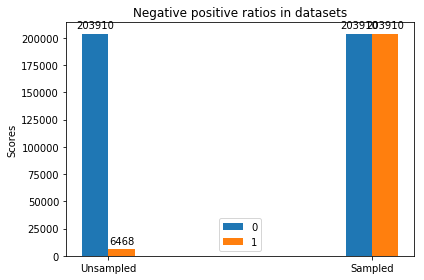

In [30]:
type(pd.Series(y_train_res))
ph.plot_binary_distribution(y_train_rule4_episode, pd.Series(y_train_res))

In [31]:
y_train_rule4_episode.value_counts()

0    203910
1      6468
Name: rule4_episode, dtype: int64

In [32]:
pd.Series(y_train_res).value_counts()

1    203910
0    203910
dtype: int64

In [37]:
print(X_train_rule4_episode.shape, X_train_res.shape)

(210378, 736) (407820, 736)


In [34]:
X_train_res

array([-2.50000000e+00,  8.98000000e+01, -1.90000000e+00, -6.30000000e+00,
        1.01680000e+03,  1.44000000e+02,  1.50000000e+01,  1.70000000e+01,
        6.00000000e+00,  5.21749195e+00,  3.30000000e+00, -1.30000000e+00,
       -2.30000000e+00,  2.30000000e+00, -1.40000000e+00, -1.60000000e+00,
       -4.30000000e+00,  1.00000000e+02,  0.00000000e+00,  0.00000000e+00,
        1.01650000e+03,  2.40000000e+02,  1.00000000e+00, -3.10000000e+01,
       -4.30000000e+01,  1.03440804e+01,  1.60000000e+00,  0.00000000e+00,
        3.00000000e-01,  1.10000000e+00,  3.00000000e-01,  4.00000000e-01,
       -7.00000000e-01,  9.31000000e+01, -3.00000000e-01, -1.00000000e+00,
        1.01710000e+03,  2.12000000e+02, -9.20000000e+01, -8.00000000e+01,
       -9.10000000e+01,  3.08544972e+01,  1.00000000e+00, -7.00000000e-01,
       -6.00000000e-01,  6.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -3.60000000e+00,  9.40000000e+01,  2.00000000e-01, -1.00000000e-01,
        1.01650000e+03,  

In [40]:
df_train_res = pd.DataFrame(columns=features, data=X_train_res)
df_train_res.head()

KLO_Air_temp  KLO_Hum  KLO_Hum_delta_3  KLO_Hum_delta_6   KLO_QNH  \
0        -2.500   89.800           -1.900           -6.300 1,016.800   
1        -2.800   91.100            0.300           -4.100 1,016.800   
2        -3.300   92.700            1.900           -1.700 1,016.900   
3        -2.900   89.800            0.000           -1.900 1,016.900   
4        -2.700   90.400           -0.700           -0.400 1,017.000   

   KLO_Wind_dir  KLO_Wind_dir_delta  KLO_Wind_dir_delta-3  \
0       144.000              15.000                17.000   
1       168.000              24.000                37.000   
2       147.000             -21.000                18.000   
3       151.000               4.000                 7.000   
4       157.000               6.000               -11.000   

   KLO_Wind_dir_delta-6  KLO_Wind_dir_spread30  KLO_Wind_max  \
0                 6.000                  5.217         3.300   
1                19.000                  9.458         3.100   
2                 2.000                 11.747         2.500   
3                24.000                 10.713         2.800   
4                26.000                  7.401         3.800   

   KLO_Wind_max_delta_3  KLO_Wind_max_delta_6  KLO_Wind_speed  \
0                -1.300                -2.300           2.300   
1                -1.900                -2.600           2.200   
2                -2.300                -1.900           1.600   
3                -0.500                -1.800           1.700   
4                 0.700                -1.200           2.200   

   KLO_Wind_speed_delta_3  KLO_Wind_speed_delta_6  BIZ_Air_temp  BIZ_Hum  \
0                  -1.400                  -1.600        -4.300  100.000   
1                  -1.900                  -1.100        -4.200  100.000   
2                  -1.900                  -1.500        -4.000  100.000   
3                  -0.600                  -2.000        -4.000  100.000   
4                   0.000                  -1.900        -3.900  100.000   

   BIZ_Hum_delta_3  BIZ_Hum_delta_6   BIZ_QNH  BIZ_Wind_dir  \
0            0.000            0.000 1,016.500       240.000   
1            0.000            0.000 1,016.600       250.000   
2            0.000            0.000 1,016.700       224.000   
3            0.000            0.000 1,016.800       239.000   
4            0.000            0.000 1,016.900       239.000   

   BIZ_Wind_dir_delta  BIZ_Wind_dir_delta-3  BIZ_Wind_dir_delta-6  \
0               1.000               -31.000               -43.000   
1              10.000               -20.000               -15.000   
2             -26.000               -15.000               -14.000   
3              15.000                -1.000               -32.000   
4               0.000               -11.000               -31.000   

   BIZ_Wind_dir_spread30  BIZ_Wind_max  BIZ_Wind_max_delta_3  \
0                 10.344         1.600                 0.000   
1                 10.863         1.600                 0.400   
2                  9.292         1.500                -0.400   
3                 10.546         1.100                -0.500   
4                 10.006         1.200                -0.400   

   BIZ_Wind_max_delta_6  BIZ_Wind_speed  BIZ_Wind_speed_delta_3  \
0                 0.300           1.100                   0.300   
1                 0.100           1.000                   0.300   
2                 0.400           0.900                  -0.400   
3                -0.500           0.500                  -0.600   
4                 0.000           0.500                  -0.500   

   BIZ_Wind_speed_delta_6  BUS_Air_temp  BUS_Hum  BUS_Hum_delta_3  \
0                   0.400        -0.700   93.100           -0.300   
1                   0.200        -0.700   93.100           -1.700   
2                   0.200        -0.800   93.400           -3.700   
3                  -0.300        -1.300   96.300            3.200   
4                  -0.200        -1.200   9

In [28]:
y_test_rule4_episode = df_unsampled_test_set.rule4_episode
X_test_rule4_episode = df_unsampled_test_set[features]
X_test_rule4_episode.head()

KLO_Air_temp  KLO_Hum  KLO_Hum_delta_3  KLO_Hum_delta_6   KLO_QNH  \
210384         8.500   72.700           -0.800            1.000 1,010.000   
210385         9.100   70.600           -2.700           -0.900 1,010.000   
210386         9.300   70.200           -3.900           -2.200 1,010.000   
210387         9.100   72.800            0.100           -0.700 1,010.000   
210388         8.500   79.300            8.700            6.000 1,010.400   

        KLO_Wind_dir  KLO_Wind_dir_delta  KLO_Wind_dir_delta-3  \
210384       224.000              -5.000                13.000   
210385       231.000               7.000                13.000   
210386       237.000               6.000                 8.000   
210387       244.000               7.000                20.000   
210388       260.000              16.000                29.000   

        KLO_Wind_dir_delta-6  KLO_Wind_dir_spread30  KLO_Wind_max  \
210384                17.000                  4.655         9.600   
210385                32.000                  4.655         9.700   
210386                34.000                  3.496        11.900   
210387                33.000                  3.859        10.300   
210388                42.000                  6.155        13.700   

        KLO_Wind_max_delta_3  KLO_Wind_max_delta_6  KLO_Wind_speed  \
210384                 1.500                 0.500           5.700   
210385                 0.500                -0.100           5.900   
210386                 2.700                 2.900           7.100   
210387                 0.700                 2.200           6.600   
210388                 4.000                 4.500           7.500   

        KLO_Wind_speed_delta_3  KLO_Wind_speed_delta_6  BIZ_Air_temp  BIZ_Hum  \
210384                   1.400                   0.100         3.900   86.900   
210385                   1.400                   0.200         4.000   86.800   
210386                   2.300                   1.700         4.500   86.600   
210387                   0.900                   2.300         4.800   82.800   
210388                   1.600                   3.000         4.700   83.600   

        BIZ_Hum_delta_3  BIZ_Hum_delta_6   BIZ_QNH  BIZ_Wind_dir  \
210384            1.000           -1.900 1,009.900       253.000   
210385            1.000           -1.100 1,009.900       250.000   
210386            2.000           -3.300 1,009.900       225.000   
210387           -4.100           -3.100 1,009.900       226.000   
210388           -3.200           -2.200 1,009.900       233.000   

        BIZ_Wind_dir_delta  BIZ_Wind_dir_delta-3  BIZ_Wind_dir_delta-6  \
210384               6.000                19.000                -8.000   
210385              -3.000               -18.000                22.000   
210386             -25.000               -22.000               -15.000   
210387               1.000               -27.000                -8.000   
210388               7.000               -17.000               -35.000   

        BIZ_Wind_dir_spread30  BIZ_Wind_max  BIZ_Wind_max_delta_3  \
210384                 13.470         1.400                -1.100   
210385                  7.348         1.200                -0.200   
210386                  8.628         1.600                -1.900   
210387                  8.400         3.200                 1.800   
210388                  8.660         4.400                 3.200   

        BIZ_Wind_max_delta_6  BIZ_Wind_speed  BIZ_Wind_speed_delta_3  \
210384                 0.000           0.700                  -0.500   
210385                -1.200           0.500                  -0.200   
210386                -1.800           0.500                  -0.400   
210387                 0.700           1.000                   0.300   
210388                 3.000           1.800                   1.300   

        BIZ_Wind_speed_delta_6  BUS_Air_temp  BUS_Hum  BUS_Hum_delta_3  \
210384                   0.100         8.000   78

In [43]:
X_test_rule4_episode.sample(20)

KLO_Air_temp  KLO_Hum  KLO_Hum_delta_3  KLO_Hum_delta_6   KLO_QNH  \
241650        19.700   69.200           -0.900            8.400 1,017.700   
221276         5.800   82.800            5.100            7.700   993.200   
246960        13.700   93.200            3.600            3.300 1,025.500   
236441        22.800   54.600           -7.800           -2.300 1,013.300   
223873         7.900   88.400           -3.100            5.900 1,009.900   
227878        13.700   60.500            1.000           -1.000 1,010.800   
227325        21.700   41.100            0.900           -2.400 1,009.400   
240680        28.100   43.300           -4.600           -7.200 1,018.000   
223724        18.100   39.000           -3.400           -3.300 1,006.600   
245033        23.400   55.900            1.100           10.400 1,015.800   
248516        15.100   77.500            3.500            8.900 1,021.700   
226042        23.100   35.500            3.900            5.300 1,025.300   
261397         4.900   74.400           -2.100            5.300 1,018.900   
246438        18.300   66.100           -0.500           -5.900 1,022.200   
252440         9.400   98.200            0.400            0.000 1,025.000   
230073        14.400   83.800            1.500            0.700 1,019.200   
257315         0.900  100.000            0.000            0.000 1,020.600   
256906         0.800   77.800           -0.800           -1.100 1,003.900   
253445         8.700   79.300            0.200           -1.300 1,008.800   
221433        -0.100   85.600            0.600            1.700 1,002.300   

        KLO_Wind_dir  KLO_Wind_dir_delta  KLO_Wind_dir_delta-3  \
241650       330.000               5.000                -9.000   
221276        54.000              -2.000                 5.000   
246960       174.000             -20.000               146.000   
236441       322.000               4.000                33.000   
223873       178.000               0.000                 7.000   
227878       265.000              73.000                 4.000   
227325        69.000               6.000                32.000   
240680       289.000             -70.000                 8.000   
223724       216.000             -19.000                -9.000   
245033       285.000              -2.000                -1.000   
248516       150.000            -152.000                97.000   
226042        53.000               0.000                -5.000   
261397       158.000               4.000                 3.000   
246438        71.000              22.000                31.000   
252440       325.000             -11.000                34.000   
230073        30.000              12.000                 7.000   
257315       341.000              -3.000               309.000   
256906        63.000               9.000                21.000   
253445       300.000             -11.000               -10.000   
221433        16.000               4.000                 2.000   

        KLO_Wind_dir_delta-6  KLO_Wind_dir_spread30  KLO_Wind_max  \
241650                39.000                  5.281         4.000   
221276                 6.000                  4.384         7.900   
246960              -137.000                 57.754         0.700   
236441               290.000                  7.280         3.300   
223873               -77.000                  6.119         5.500   
227878               -72.000                 31.131         1.700   
227325                21.000                  6.464         5.800   
240680                88.000                118.797         3.900   
223724               -36.000                  7.520         6.500   
245033                 3.000                  0.745         8.600   
248516               136.000                105.095         1.200   
226042               -15.000                  1.667         4.200   
261397               -43.000                  2.517         6.900   
246438              -187.000         

In [46]:
df_train_res.describe()

KLO_Air_temp     KLO_Hum  KLO_Hum_delta_3  KLO_Hum_delta_6     KLO_QNH  \
count   407,820.000 407,820.000      407,820.000      407,820.000 407,820.000   
mean         10.505      67.218           -0.310           -0.710   1,019.807   
std           8.046      19.101            3.192            4.809       6.910   
min         -17.500      16.500          -35.100          -36.500     977.000   
25%           4.400      51.300           -1.838           -3.169   1,016.000   
50%          10.595      67.400           -0.300           -0.600   1,020.238   
75%          16.418      83.900            1.049            1.430   1,024.400   
max          36.500     100.000           54.400           60.000   1,044.300   

       KLO_Wind_dir  KLO_Wind_dir_delta  KLO_Wind_dir_delta-3  \
count   407,820.000         407,820.000           407,820.000   
mean        130.028               0.125                -0.036   
std         103.495              53.335                70.143   
min           0.000            -349.000              -349.000   
25%          51.467              -6.000                -9.000   
50%          66.910               0.054                 0.583   
75%         223.000               7.000                10.995   
max         360.000             349.000               349.000   

       KLO_Wind_dir_delta-6  KLO_Wind_dir_spread30  KLO_Wind_max  \
count           407,820.000            407,820.000   407,820.000   
mean                 -0.498                 14.920         6.633   
std                  79.668                 27.128         3.813   
min                -349.000                  0.000         0.100   
25%                 -10.482                  3.266         3.000   
50%                   1.000                  5.735         6.877   
75%                  14.000                 10.929         9.515   
max                 349.000                199.767        28.900   

       KLO_Wind_max_delta_3  KLO_Wind_max_delta_6  KLO_Wind_speed  \
count           407,820.000           407,820.000     407,820.000   
mean                  0.025                 0.121           4.160   
std                   1.424                 1.724           2.460   
min                 -16.000               -23.300           0.000   
25%                  -0.771                -0.833           1.900   
50%                   0.000                 0.098           4.200   
75%                   0.800                 1.017           6.023   
max                  19.600                20.100          16.100   

       KLO_Wind_speed_delta_3  KLO_Wind_speed_delta_6  BIZ_Air_temp  \
count             407,820.000             407,820.000   407,820.000   
mean                    0.022                   0.087         9.964   
std                     0.960                   1.186         8.027   
min                    -9.300                 -11.100       -14.500   
25%                    -0.532                  -0.600         3.800   
50%                     0.000                   0.056         9.909   
75%                     0.590                   0.729        15.900   
max                    10.500                  11.700        35.300   

          BIZ_Hum  BIZ_Hum_delta_3  BIZ_Hum_delta_6     BIZ_QNH  BIZ_Wind_dir  \
count 407,820.000      407,820.000      407,820.000 407,820.000   407,820.000   
mean       74.835           -0.352           -0.822   1,020.131       124.883   
std        20.471            3.509            5.876       6.920        96.493   
min        12.900          -56.200          -60.200     976.200         0.000   
25%        58.600           -1.624           -3.206   1,016.400        48.336   
50%        75.788            0.000            0.000   1,020.657        68.000   
75%        96.500            0.455            0.618   1,024.763       231.000   
max       100.000           52.100           63.700   1,044.900       360.000   

       BIZ_Wind_dir_delta  BIZ_Wind_dir_delta-3  BIZ_Wind_dir_delta-6  \
count        

### Conclusion on verification of upsampled data
#### Alternative to data engineering
While producing new data, extending the dataset till a balance on the target is attained, SMOTE upsampling is to be considered as an alternative to feature engineering. The produced data fall well within the range of the original data, providing 'legitimate' values, the added values within the engineered feature do not preserve the significance of the engineered data. An example: the engineered features around lagged differences are no longer time delayed differences of the original features, but consist mainly of interpolated values similar to the unsampled values, but without their significance.

#### Upsampling with original and engineered features, training on original features
Engineered features can play a significant role for the KNN algorithm in the search for new points in the data space during upsampling, they should be dropped in the train test process, as they do not feed the model with the significance they should.

#### Unchartered Waters
Verifications proved that the dataset grew so much larger in size, the year values had been transformed to floats, retaining a good balance between the years.. This is probably a contradiction with the time series nature of the data. It is not clear whether the upsampled data retain the seasonality characteristics of the original data.

In [1]:
dh.store_df_as_csv_compressed(df_train_res, 'model_sampled_data.csv.zip')

NameError: name 'dh' is not defined

### Train the XGBoost model on sampled data

In [42]:
# in the direction of more conservative model
#hyperparams = {'eta': 0.1, 'min_child_weight': 5, 'max_depth': 3, 'gamma': 10, 'n_estimators':1000, "eval_metric": "auc"}
hyperparams = {'n_estimators':1000, "eval_metric": "auc"}
model_smote, score_smote, cm_smote = xh.run_xgboost_prediction(df_train_res, y_train_res, X_test_rule4_episode, y_test_rule4_episode, const.steps_2_hours, '../03_serializations', **hyperparams)

KeyboardInterrupt: 

gamma [default=0, alias: min_split_loss]

Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.